# Sber e-inteship


# задача :
Для временного ряда в файле data.csv необходимо построить модель, которая оценивает обьем стабильной части средств на дату. 

Например:
model_forecast
(2019-02-01, ‘1М’, История_до_2019-02-01) = стабильная часть на 1М
Возможные горизонты: 1М, 2М, 3М, 4М, 5М, 6М, 7М, 8М, 9М, 10М, 11М, 12М

Критерии качества модели:
Нужно одновременно минимизировать величины:

1) максимальный объем пробития стабильный части на валидационной выборке

2) фактическая стабильная часть – модельная стабильная часть 

Можно применять любые подходы. Как вариант: построить квантильную регрессию для прогнозирования ряда.

In [5]:

import warnings
warnings.filterwarnings('ignore')


import pandas as pd
import numpy as np
import datetime
from sklearn.metrics import mean_absolute_error, mean_squared_error



import matplotlib.pyplot as plt

# работа с данными

импортируем данные, смортим на них

In [6]:
# я работал в гугл колаб, если решите запускать в нем, то код чтения из файла в комментарии
#data = pd.read_csv('/content/data.csv' , sep=';')
data = pd.read_csv('data.csv' , sep=';')

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   REPORTDATE  2111 non-null   object
 1   VALUE       2111 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 33.1+ KB


In [8]:
data.sample(2)

,REPORTDATE,VALUE
143,22.05.2014,17118645449
823,01.04.2016,19040608807


In [9]:
data['REPORTDATE'] = pd.to_datetime(data['REPORTDATE'], format='%d.%m.%Y', errors='ignore')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   REPORTDATE  2111 non-null   datetime64[ns]
 1   VALUE       2111 non-null   int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 33.1 KB


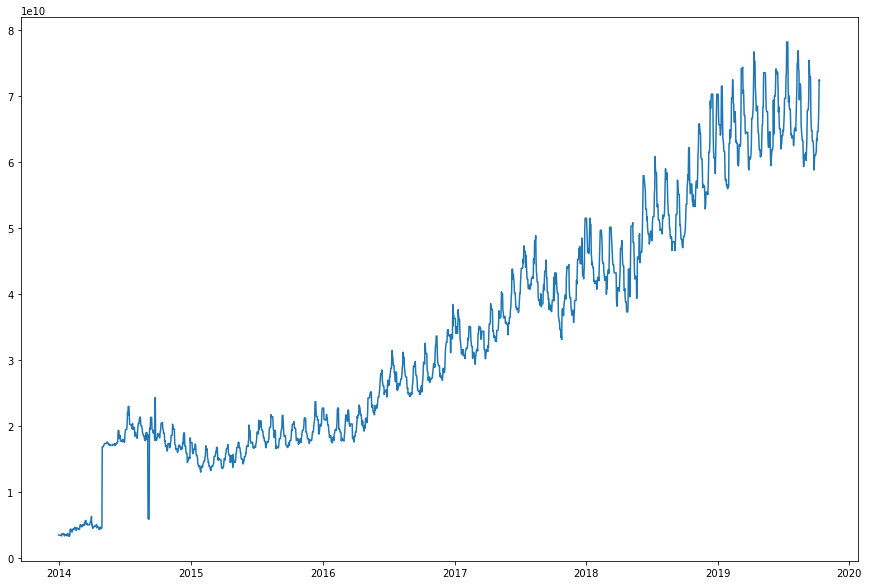

In [10]:
plt.figure(figsize=(15, 10))
plt.plot( data['REPORTDATE'] , data['VALUE'])
plt.show()

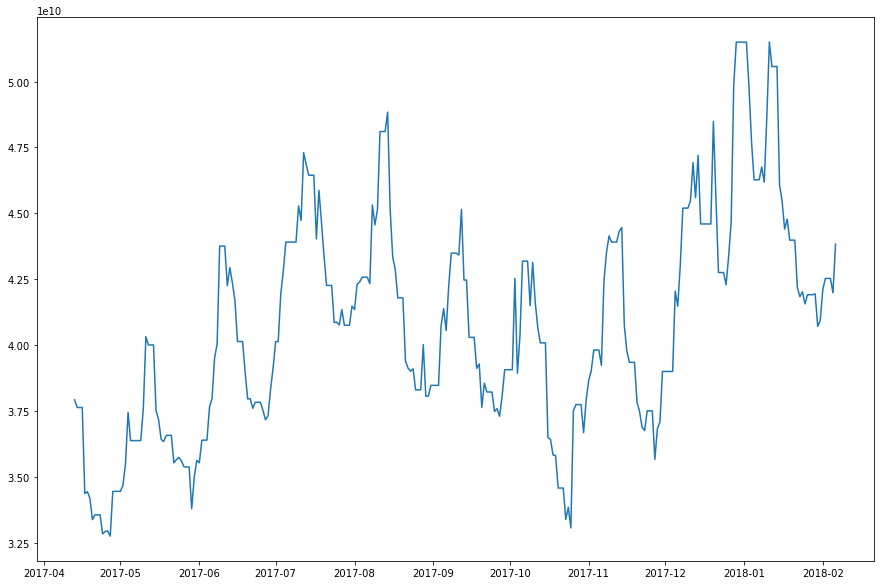

In [11]:
plt.figure(figsize=(15, 10))
plt.plot( data['REPORTDATE'][1200:1500] , data['VALUE'][1200:1500])
plt.show()

визуальная оценка данных дает нам:

1) 2014-2015гг - поведение не свойственное данным в дальнейшем, для обучения имеет смысл убрать эти данные

2) мы наблюдаем годичную и месячную цикличность, это имеет смысл учитывать. Плюс можно сделать предположение, что недельной цикличности не будет т.к. у большинства клиентов цикл пополнения счета привязан к месячным циклам(вклады/кредиты/ЗП/комунльные услуги...)

3) с ростом общего объема денежной массы, растет и разброс minmax в течении циклов

для предсказания поведения в данном случае лучше всего подходит линейная регрессия, а точнее ансамбль из линейных регрессий:

1) baseline - общий тренд

2) годичный тренд

3) месячный тренд

In [12]:
# clean out non-representative period
data = data[data['REPORTDATE'] >= '01.01.2015' ]

In [13]:
data['dayfromstart'] = data['REPORTDATE'].apply(lambda x: ((x - data['REPORTDATE'][367]))/ np.timedelta64(1, "D"))

In [14]:
data.head(5)

,REPORTDATE,VALUE,dayfromstart
367,2015-01-01,17452425921,0.0
368,2015-01-02,17452425921,1.0
369,2015-01-03,17452425921,2.0
370,2015-01-04,17452425921,3.0
371,2015-01-05,16162817600,4.0


# baseline

или общая линейная регрессия за весь пероид


In [15]:
#from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae

In [16]:
LR = LinearRegression()
LR_BL = LinearRegression()
X = np.array([data['dayfromstart']]).T
y = np.array([data['VALUE']]).T

In [17]:
LR_BL.fit(X,y)

LinearRegression()

In [18]:
y_pred_alltime =  LR_BL.predict(X)

In [19]:
print(mse(y , y_pred_alltime))
print(mae(y , y_pred_alltime))
print(mae(y , y_pred_alltime) / y.mean())

1.892218661497593e+19
3432052212.911134
0.0898962583149827


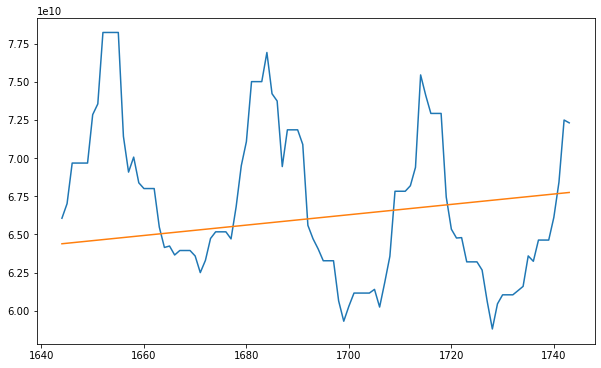

In [20]:
plt.figure(figsize=(10, 6))
plt.plot( X[1644:] , y[1644:])
plt.plot( X[1644:] , y_pred_alltime[1644:])
plt.show()

In [21]:
data['baseline_predict'] = y_pred_alltime
data.sample(5)

,REPORTDATE,VALUE,dayfromstart,baseline_predict
493,2015-05-07,15862756352,126.0,1.288325e+10
1699,2018-08-25,48565801128,1332.0,5.380259e+10
539,2015-06-22,16690999913,172.0,1.444402e+10
1297,2017-07-19,44676507506,930.0,4.016281e+10
508,2015-05-22,14926587376,141.0,1.339220e+10


# baseline + годичные и месячные циклы

baseline нашел основную тендецию, переходим к feature engineering , добавляя годичный и месячный циклы

In [22]:
lag = data['REPORTDATE'][367]
def data_f_e(data , lag):
  # вытаскиваем из данных признаки
  data['dayfromstart'] = data['REPORTDATE'].apply(lambda x: ((x - lag))/ np.timedelta64(1, "D"))
  data['month'] = data['REPORTDATE'].apply(lambda x: x.month)
  data['year'] = data['REPORTDATE'].apply(lambda x: x.year)
  data['day_in_month'] = data['REPORTDATE'].apply(lambda x: x.day)
  data['day_in_year'] = data['REPORTDATE'].apply(lambda x: x.day + ((x.month-1) * 31))
  for i in set(data['year']):
    data.loc[data[data['year'] == i].index , 'year_mean'] = data[data['year'] == i]['VALUE'].mean()

    data_year = data[data['year'] == i]
    for j in set(data_year['month']):
      data.loc[ data_year[data_year['month'] == j].index ,'month_mean'] = data_year[data_year['month'] == j]['VALUE'].mean()
  data['bl_pred_error'] = data['VALUE'] - data['baseline_predict']
  data = data.reset_index(drop=True)
  return data

In [23]:
data = data_f_e(data, lag)

In [24]:
data.loc[[0]]

,REPORTDATE,VALUE,dayfromstart,baseline_predict,month,year,day_in_month,day_in_year,year_mean,month_mean,bl_pred_error
0,2015-01-01,17452425921,0.0,8.608097e+09,1,2015,1,1,1.728027e+10,1.538473e+10,8.844329e+09


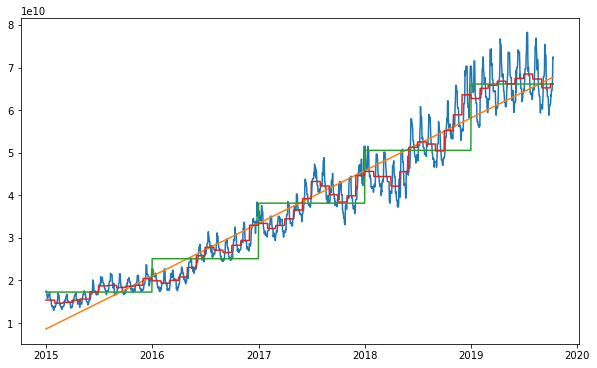

In [25]:
plt.figure(figsize=(10, 6))
for i in ['VALUE','baseline_predict','year_mean','month_mean']:
  plt.plot(data['REPORTDATE'] , data[i])
plt.show()

теперь строим модели по каждому месяцу (даем на вход день с начала отсчета и бэйзлайн предикт), ансамблируем
строим модель по каждому году (даем на вход день с начала отсчета и бэйзлайн предикт), ансамблируем

делаем предсказания по каждой из моделей 

In [26]:

month_preds = pd.DataFrame([])
year_preds = pd.DataFrame([])
for i in set(data['year']):
  data_year = data[data['year'] == i] 

  LR.fit(data_year[['day_in_year' , 'baseline_predict', 'year' , 'dayfromstart' , 'month' ]] ,  
         data_year['VALUE']-data_year['baseline_predict'])
  
  y_year = LR.predict(data_year[['day_in_year' , 'baseline_predict', 'year' , 'dayfromstart' , 'month' ]])

  year_preds  =  year_preds.append(pd.DataFrame(y_year))

data['year_preds'] = year_preds.reset_index(drop=True)


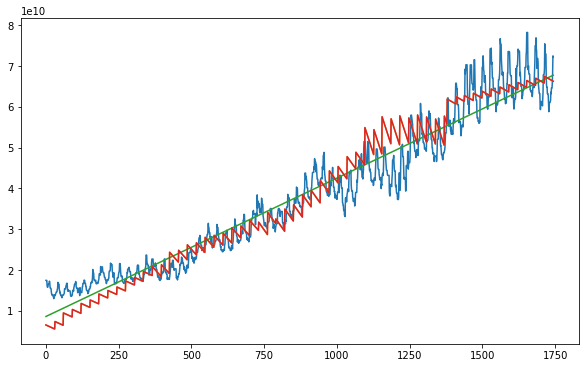

In [27]:

y = data['baseline_predict'] +data['year_preds']
plt.figure(figsize=(10, 6))
for i in ['VALUE','baseline_predict']:
  plt.plot(data['dayfromstart'] , data[i])
  plt.plot(data['dayfromstart'] , y)
plt.show()

In [28]:
for i in set(data['year']):
  data_year = data[data['year'] == i]

  for j in set(data_year['month']):
    data_month = data_year[data_year['month'] == j]
    y = data_month['VALUE']-data_month['baseline_predict']-data_month['year_preds']

    LR.fit(data_month[['day_in_month'  , 'baseline_predict', 'year' , 'dayfromstart' , 'month', 'year_preds' ]] , y)
    y_month = LR.predict(data_month[['day_in_month'  , 'baseline_predict', 'year' , 'dayfromstart' , 'month' , 'year_preds' ]])

    month_preds  =  month_preds.append(pd.DataFrame(y_month))
    
data['month_preds'] = month_preds.reset_index(drop=True)

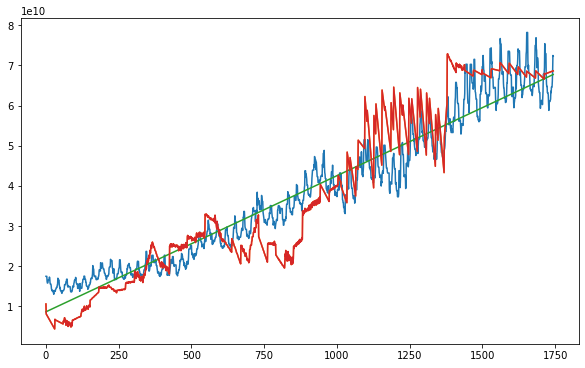

In [29]:
y = data['baseline_predict'] +data['year_preds'] + data['month_preds']
plt.figure(figsize=(10, 6))
for i in ['VALUE','baseline_predict' ]:
  plt.plot(data['dayfromstart'] , data[i])
  plt.plot(data['dayfromstart'] , y)
plt.show()

In [30]:
print(mse(y , data['baseline_predict'] + data['month_preds']))
print(mae(y , data['baseline_predict'] + data['month_preds']))
print(mae(y , data['baseline_predict'] + data['month_preds']) / y.mean())

8.718943256175872e+18
2420012605.846455
0.06338072934199254


в целом видна тенденция к правильному решению, но из-за того, что мы каждый раз учимся по новой, мы заметно теряем в удержании основного тренда.

решение - сделать LR осноыного тренда по всем данным, 
а модели местных трендов делать по метаданным, обученым на всей выборке сразу( боремся с проблемой переобучения и получаем усредненный тренд, учитывая опыт всех собранных данных)

 # смещение трендов

In [31]:
def LR_combines(df , cols , y):
  mse_y = {}
  for bias in range(365):
    LR.fit(df[bias: len(df)][cols] , y[bias : len(y)])
    y_pred = LR.predict(df[bias: len(df)][cols])

    mse_y[bias] =[bias ,  mse( y[bias : len(y)] , y_pred)]

  return mse_y 

def LR_get_pred(df , y_dict , cols , y , df_for_pred='no_mean'):
  msey = pd.DataFrame( y_dict ).T
  msey.columns = ['bias' , 'mse']
  pred_bias = int(msey[ msey['mse'] == msey['mse'].min()]['bias'].values[0])
  
  LR.fit(df[pred_bias: len(df)][cols] , y[pred_bias : len(y)])
  if type(df_for_pred) == str :
    return  LR.predict(df[cols])
  else:
    return  LR.predict(df_for_pred[cols])

In [32]:
#разница ошибок была очень велика, мы делаем смещение( bias) с самой меньшей ошибкой из возможных ( 364 дня). 
# И строим с этим смещением LR, корректирующий наш BL

In [33]:
cols_for_year = ['day_in_year' , 'year', 'month' ]
cols_for_month =['day_in_month' , 'month', 'day_in_year' , 'year_preds']
year_y = data['VALUE'] - data['baseline_predict']
month_y = data['VALUE'] - data['baseline_predict'] - data['year_preds']


mse_year = LR_combines(data , cols_for_year , year_y)
data['year_preds'] = LR_get_pred(data , mse_year , cols_for_year , year_y)

In [34]:
mse_month = LR_combines(data , cols_for_month , month_y)

data['month_preds'] = LR_get_pred(data , mse_month , cols_for_month , month_y)

In [35]:
mse(data['VALUE'] , data['baseline_predict'] + data['month_preds'] + data['year_preds'])

1.9518605352669745e+19

In [36]:
data.head(1)

,REPORTDATE,VALUE,dayfromstart,baseline_predict,month,year,day_in_month,day_in_year,year_mean,month_mean,bl_pred_error,year_preds,month_preds
0,2015-01-01,17452425921,0.0,8.608097e+09,1,2015,1,1,1.728027e+10,1.538473e+10,8.844329e+09,-1.992691e+09,2.452699e+09


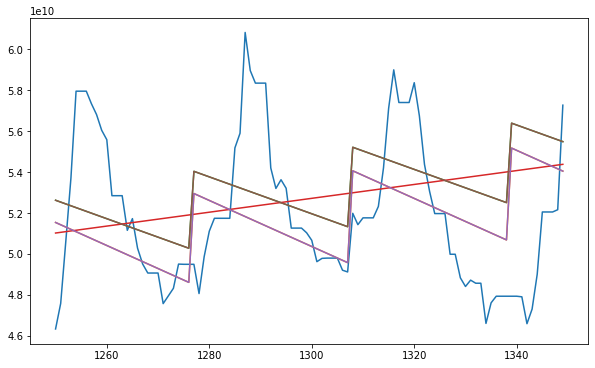

In [37]:
y = data['baseline_predict'] +data['year_preds'] + data['month_preds']
y2 = data['baseline_predict'] +data['year_preds']
plt.figure(figsize=(10, 6))
for i in ['VALUE','baseline_predict' ,]:
  plt.plot(data['dayfromstart'][1250:1350] , data[i][1250:1350])
  plt.plot(data['dayfromstart'][1250:1350] , y[1250:1350])
  plt.plot(data['dayfromstart'][1250:1350] , y2[1250:1350])
plt.show()

сейчас мы видим, что линейных зависимостей не хватает, а значит имеет смысл добавить функцию Feature Engineeniring-a , которой мы проверим синусы, косинусы, квадраты, корни и экспаненты наших уже добытых данных на информативность

# итоговая модель общего тренда на overfeated data

In [38]:
import math

In [39]:
data = data.drop(['year_mean', 'month_mean' ] , axis = 1)
# этих данных не будет в предсказываемых периодах, их использовать не получится

In [40]:
data.head(1)

,REPORTDATE,VALUE,dayfromstart,baseline_predict,month,year,day_in_month,day_in_year,bl_pred_error,year_preds,month_preds
0,2015-01-01,17452425921,0.0,8.608097e+09,1,2015,1,1,8.844329e+09,-1.992691e+09,2.452699e+09


In [41]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler_value = MinMaxScaler()

In [42]:
data_cols = data.columns.drop(['VALUE' , 'REPORTDATE', 'bl_pred_error' ])
data_cols

Index(['dayfromstart', 'baseline_predict', 'month', 'year', 'day_in_month',
       'day_in_year', 'year_preds', 'month_preds'],
      dtype='object')

In [43]:
scaler.fit(data[data_cols].values)
scaled_data = pd.DataFrame(data = scaler.transform(data[data_cols].values) , columns = data_cols)

scaler_value.fit([data['VALUE'].values])
scaled_value = scaler_value.transform([data['VALUE'].values])

In [44]:
def features(data , cols):
  try :
    cols.drop('VALUE')
  except:
    pass
  for i in cols:
    data['{}_**2'.format(i)] = data[i].apply(lambda x : x ** 2)
    data['{}_exp'.format(i)] = data[i].apply(lambda x : math.exp(x))
    #data['{}_**2'.format(i)] = data[i].apply(lambda x : math.log(x+1))
    data['{}_sqrt'.format(i)] = data[i].apply(lambda x : math.sqrt(math.fabs(x)))
  return data 

In [45]:
overfeated_data = features(scaled_data , data_cols)

In [46]:
overfeated_data.columns

Index(['dayfromstart', 'baseline_predict', 'month', 'year', 'day_in_month',
       'day_in_year', 'year_preds', 'month_preds', 'dayfromstart_**2',
       'dayfromstart_exp', 'dayfromstart_sqrt', 'baseline_predict_**2',
       'baseline_predict_exp', 'baseline_predict_sqrt', 'month_**2',
       'month_exp', 'month_sqrt', 'year_**2', 'year_exp', 'year_sqrt',
       'day_in_month_**2', 'day_in_month_exp', 'day_in_month_sqrt',
       'day_in_year_**2', 'day_in_year_exp', 'day_in_year_sqrt',
       'year_preds_**2', 'year_preds_exp', 'year_preds_sqrt',
       'month_preds_**2', 'month_preds_exp', 'month_preds_sqrt'],
      dtype='object')

In [47]:
X = overfeated_data
y = data['VALUE']

In [48]:
LR_final = LinearRegression()
LR_final.fit(X , y)
y_pred = LR_final.predict(X)

In [49]:
print(mse( y , y_pred))
print(mae( y , y_pred))
print(mae(y , y_pred) / y.mean())

6.064316930794737e+18
1786438267.2247705
0.0467924454441761


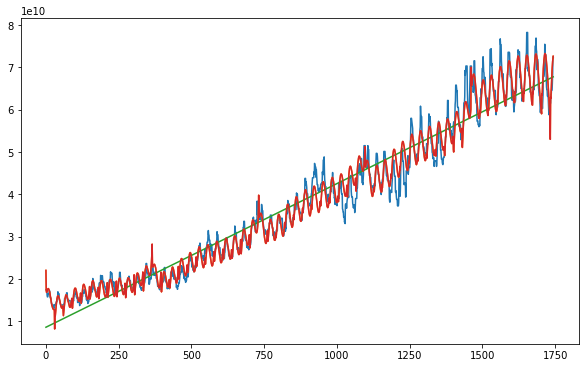

In [50]:
y = y_pred
plt.figure(figsize=(10, 6))
for i in ['VALUE','baseline_predict' ]:
  plt.plot(data['dayfromstart'] , data[i])
  plt.plot(data['dayfromstart'] , y)
plt.show()

новая модель имеет очень большое количесво фичей, но оптимизировать это я не буду, т.к. нам не так важна производительность, как точность.

а точность предсказания таким образом нам получилось поднять до:

MSE - 6.052833262019203e+18

MAE - 1786209980.1353211

отклонение в % - 4.6786465886206115

# predict  на разный горизонт

In [51]:
#data_cols = data_cols.drop(['year_preds', 'month_preds'])
data_cols

Index(['dayfromstart', 'baseline_predict', 'month', 'year', 'day_in_month',
       'day_in_year', 'year_preds', 'month_preds'],
      dtype='object')

In [52]:
def data_eng(data ):
  # вытаскиваем из данных признаки
  data['dayfromstart'] = data['REPORTDATE'].apply(lambda x: ((x - data['REPORTDATE'].loc[[0]])/ np.timedelta64(1, "D"))) + 1774 
  data['month'] = data['REPORTDATE'].apply(lambda x: x.month)
  data['year'] = data['REPORTDATE'].apply(lambda x: x.year)
  data['day_in_month'] = data['REPORTDATE'].apply(lambda x: x.day)
  data['day_in_year'] = data['REPORTDATE'].apply(lambda x: x.day + ((x.month-1) * 31))

  X = np.array([data['dayfromstart']]).T
  data['baseline_predict'] = LR_BL.predict(X)

  data = data.reset_index(drop=True)
  return data

In [53]:
def generate_data( monthes  ):
  last_date = data[data['dayfromstart'] == data['dayfromstart'].max()]['REPORTDATE'][1743]
  #y = np.arange(last_date , last_date + np.timedelta(monthes , 'M', dtype='datetime64[D]'))
  # при таком решении среда выполнения google colab падает от перегруза ОЗУ
  iter = 0
  act_date = data[data['dayfromstart'] == data['dayfromstart'].max()]['REPORTDATE'][1743]
  datas = pd.DataFrame(data = [act_date] )
  last_date = act_date + np.timedelta64(monthes , 'M')
  while act_date < last_date:
    iter += 1
    act_date = act_date + np.timedelta64( 1 , 'D')
    datas[iter] = (act_date)
  y = datas.T
  y.columns = ['REPORTDATE']
  
  
  y = data_eng(y)
  
  y['year_preds'] = LR_get_pred(data , mse_year , cols_for_year , year_y, df_for_pred = y)
  y['month_preds'] = LR_get_pred(data , mse_month , cols_for_month , month_y, df_for_pred = y)

  scaled_y = pd.DataFrame(data = scaler.transform(y[data_cols].values) , columns = data_cols)
  overfeated_y = features(scaled_y , data_cols)
  return overfeated_y

In [54]:
X = generate_data(12)
X
y_pred = LR_final.predict(X)


In [55]:
def get_predict( monthes ):
  X = generate_data( monthes)
  y_pred = LR_final.predict(X)
  money_count = y_pred+ X['year_preds'] +X['month_preds']+X['baseline_predict']
  
  answer = money_count.min()


  plt.figure(figsize=(10, 6))
  plt.plot(X['dayfromstart'] , money_count)
  plt.plot(X['dayfromstart'],np.full(X.shape[0] ,answer) )
  plt.show()
  return print('{} = стабильная часть на горизонт {} Месяца '.format(answer , monthes))

# получаем предсказание:
для примера значение месяцев = 4

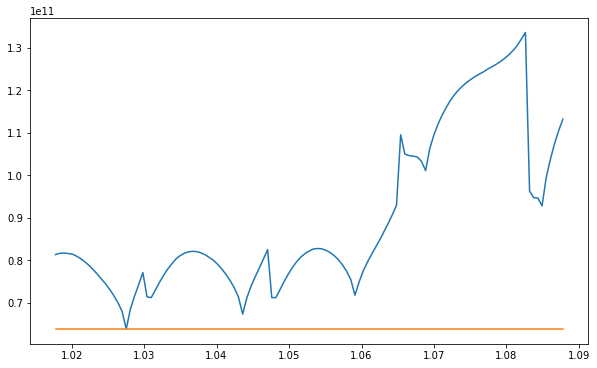

63833505793.68095 = стабильная часть на горизонт 4 Месяца 


In [56]:
get_predict(4)